In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib
import pandas as pd
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy
import gudhi
from gudhi.wasserstein import wasserstein_distance
from astropy.cosmology import WMAP9 as cosmo

import astroML

# from astroML.datasets import fetch_sdss_galaxy_colors
import ripser
import persim


%config InlineBackend.figure_format='retina'


2023-08-15 17:42:28.931799: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 17:42:30.734131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 17:42:30.735747: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/taceroc/miniconda3/envs/lssds/lib/python3.10/site-packages/ot/backend.p

In [2]:
# Fetch and prepare the data
from astroML.datasets import fetch_sdss_specgals
data = fetch_sdss_specgals()

df = pd.DataFrame(data)

df.shape

(661598, 43)

## Extract RA, DEC and Redshift of each galaxie and convert to XYZ

In [3]:
# Create a SkyCoord object with the given RA, DEC, and redshift
coord = SkyCoord(ra=df["ra"].values*u.degree, dec=df["dec"].values*u.degree, distance=cosmo.luminosity_distance(df["z"].values))

# Convert to Cartesian coordinates (x, y, z)
# in Mpc
x = coord.cartesian.x.value
y = coord.cartesian.y.value
z = coord.cartesian.z.value

In [4]:
data = np.arange(0, len(x))
# Calculate the number of elements to extract (20%)
num_elements = int(len(data) * 0.0010)

np.random.seed(343)
# Randomly choose indices of elements to extract
selected_indices = np.random.choice(len(data), size=num_elements, replace=False)

# Extract the selected elements
x_redu = x[selected_indices]
y_redu = y[selected_indices]
z_redu = z[selected_indices]

In [5]:
x_redu.shape

(661,)

In [6]:
# define the size of the slices in the data for the batches
asr = np.linspace(0, len(x_redu), 7)
asr

array([  0.        , 110.16666667, 220.33333333, 330.5       ,
       440.66666667, 550.83333333, 661.        ])

In [7]:
initial = [int(ij) for ij in asr[0:-1]]
final = [int(ij) for ij in asr[1:]]

In [8]:
initial, final

([0, 110, 220, 330, 440, 550], [110, 220, 330, 440, 550, 661])

# Create a Persistence Diagram per batches.

In [9]:
diag = []
trees = []
colormap = plt.cm.Set1.colors
for ix, fx in zip(initial, final):
    for iy, fy in zip(initial, final):
        for iz, fz in zip(initial, final):
            
            xx = x_redu.copy()[ix:fx]
            yy = y_redu.copy()[iy:fy]
            zz = z_redu.copy()[iz:fz]

            if (xx.shape == yy.shape == zz.shape):
                points_d = np.vstack([xx, yy, zz]).reshape(len(xx), 3)
                ac = gudhi.AlphaComplex(points = points_d)

                simplex_tree = ac.create_simplex_tree(max_alpha_square = 5000)
                diag_1 = simplex_tree.persistence()
                # print("betti_numbers() = %s"%(simplex_tree.betti_numbers()))

                trees.append(simplex_tree)
                # betti.append(simplex_tree.betti_numbers())
                diag.append(diag_1)
            else:
                lenght = np.min([xx.shape[0], yy.shape[0], zz.shape[0]])
                xx = xx[:lenght]
                yy = yy[:lenght]
                zz = zz[:lenght]
                
                points_d = np.vstack([xx, yy, zz]).reshape(len(xx), 3)
                ac = gudhi.AlphaComplex(points = points_d)

                simplex_tree = ac.create_simplex_tree(max_alpha_square = 5000)
                diag_1 = simplex_tree.persistence()
                # print("betti_numbers() = %s"%(simplex_tree.betti_numbers()))

                trees.append(simplex_tree)
                # betti.append(simplex_tree.betti_numbers())
                diag.append(diag_1)



In [10]:
len(diag)

216

# Save the diagrams and the simplex tree

In [11]:
import pickle
# Save the list to a file using pickle
with open('digrams_final.pkl', 'wb') as file:
    pickle.dump(diag, file)

with open('simplex_trees_final.pkl', 'wb') as file:
    pickle.dump(trees, file)

# Load the diagrams and the simplex tree

In [12]:
# import pickle
with open('simplex_trees_final.pkl', 'rb') as file:
    trees = pickle.load(file)

with open('digrams_final.pkl', 'rb') as file:
    diag = pickle.load(file)

In [13]:
len(diag)

216

In [14]:
216 // 9

24

# Plot some PD

usetex mode requires TeX.
/tmp/ipykernel_20503/1173808234.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


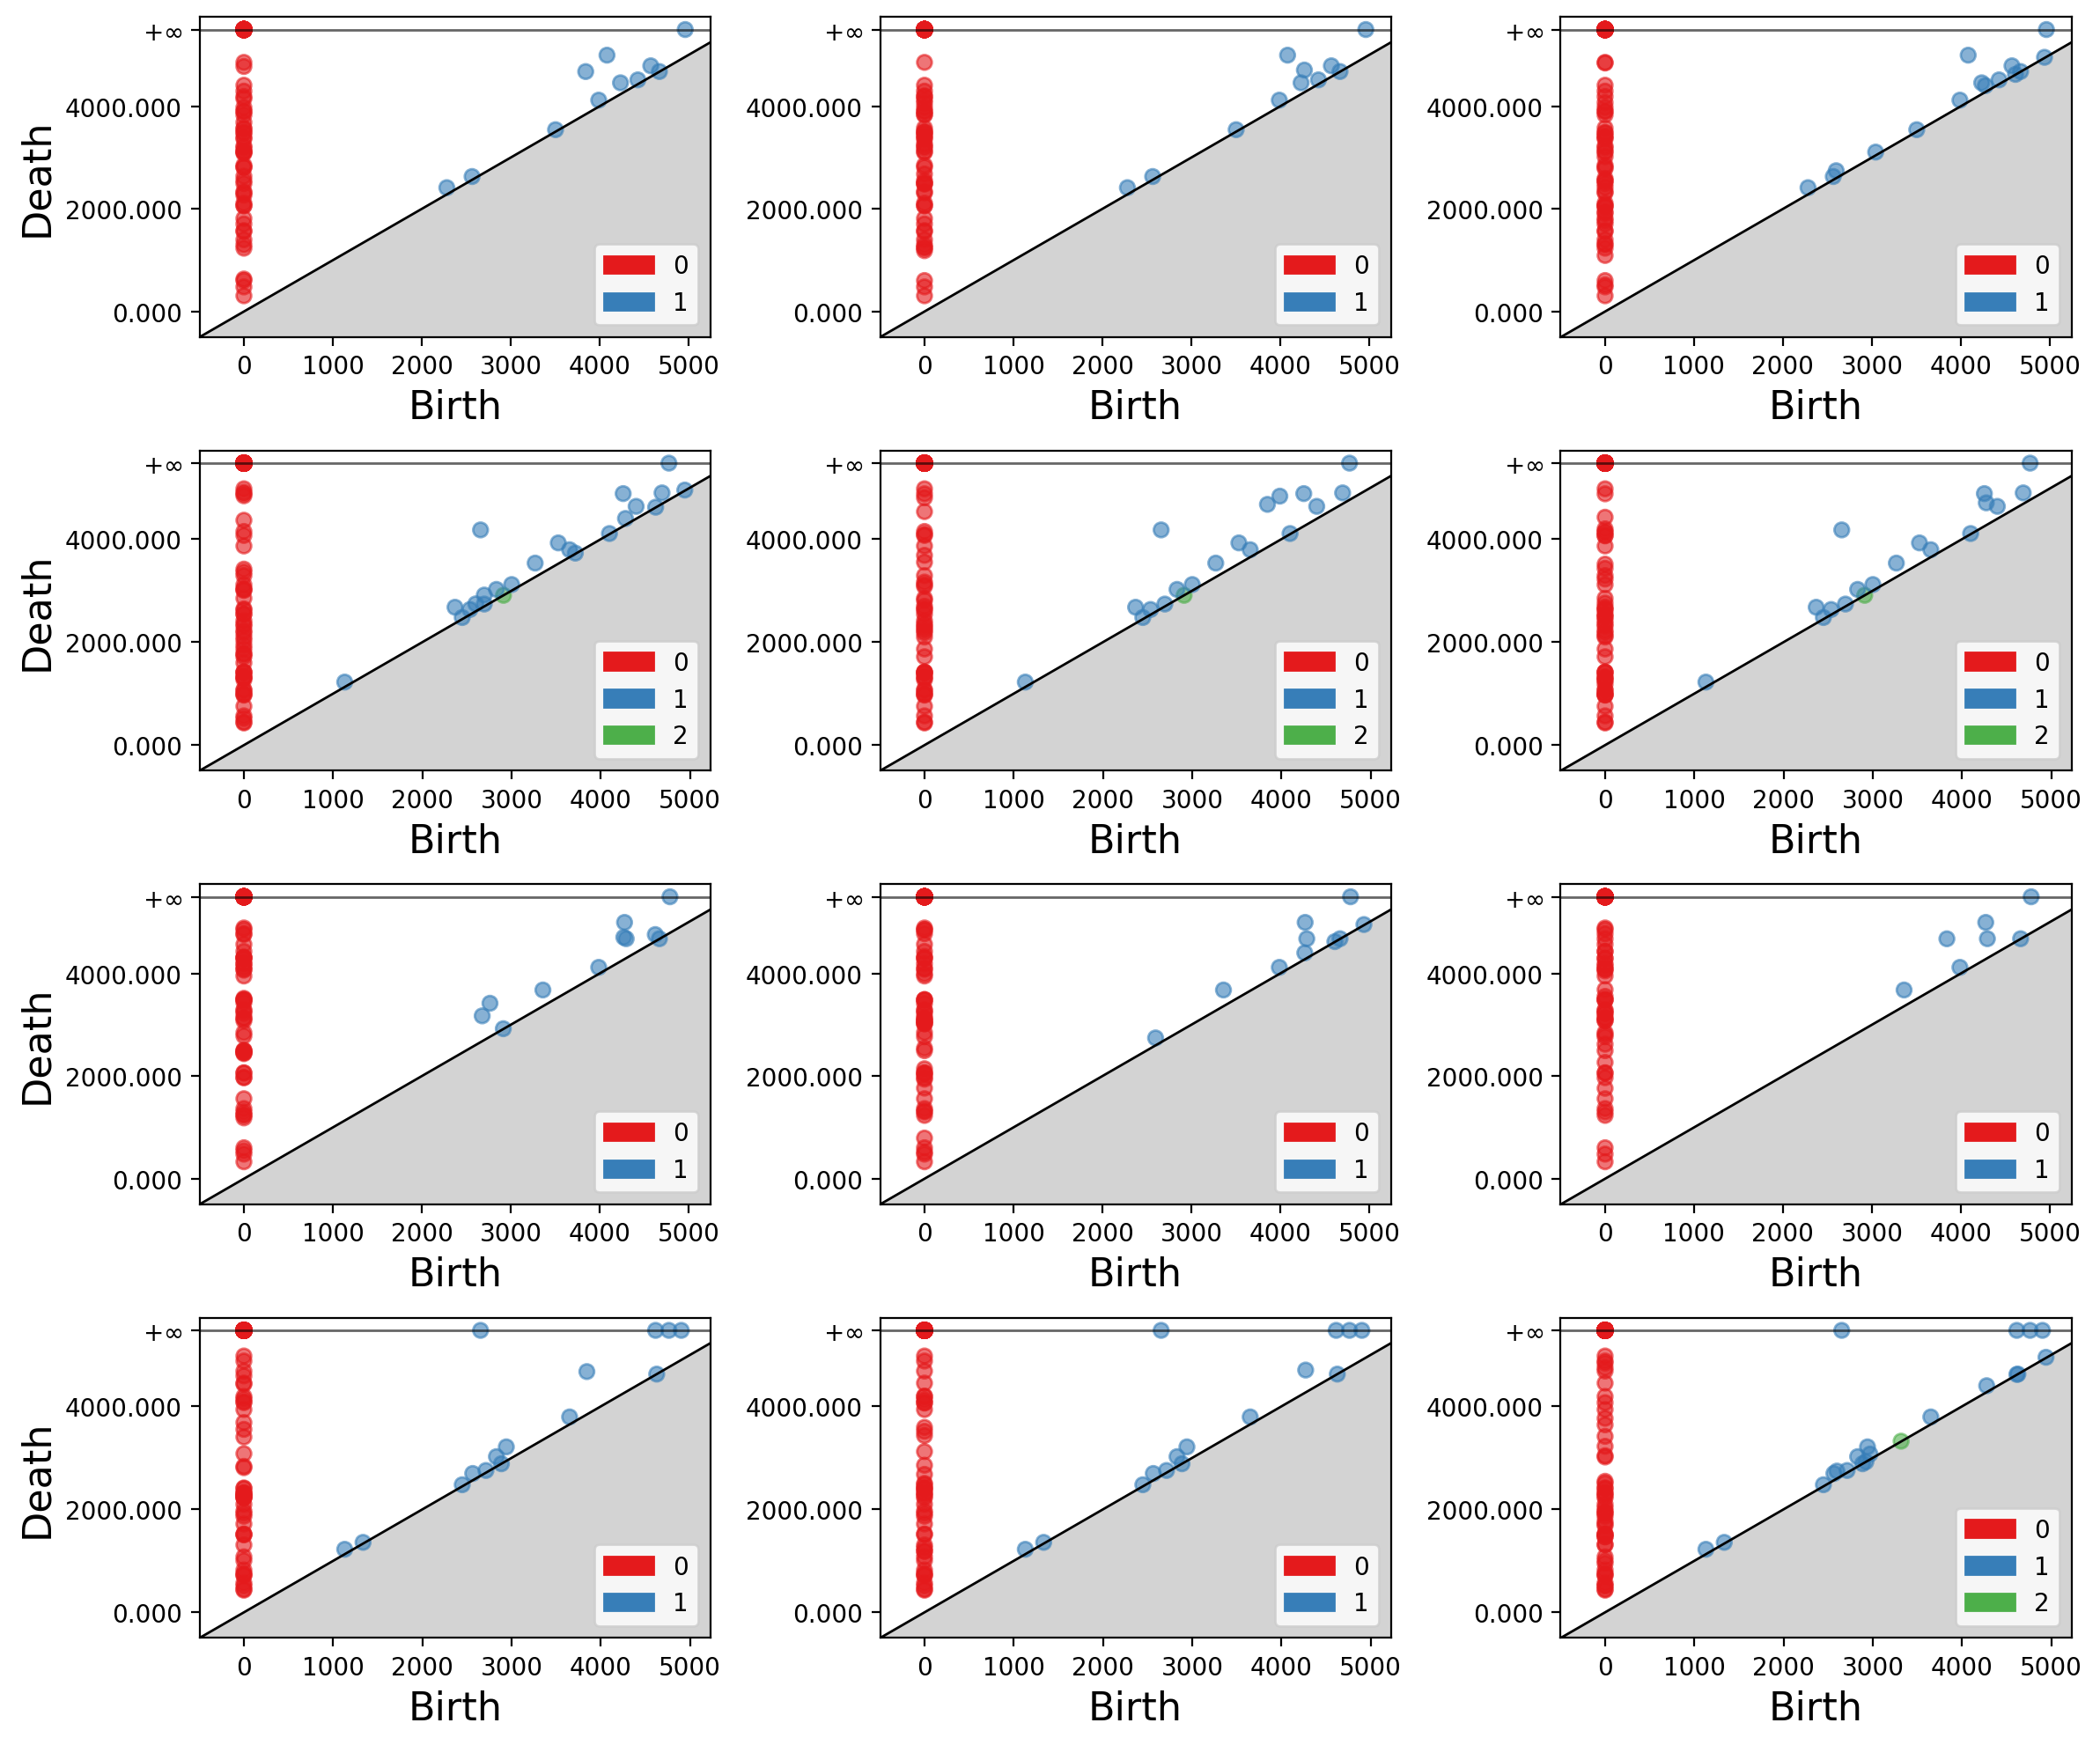

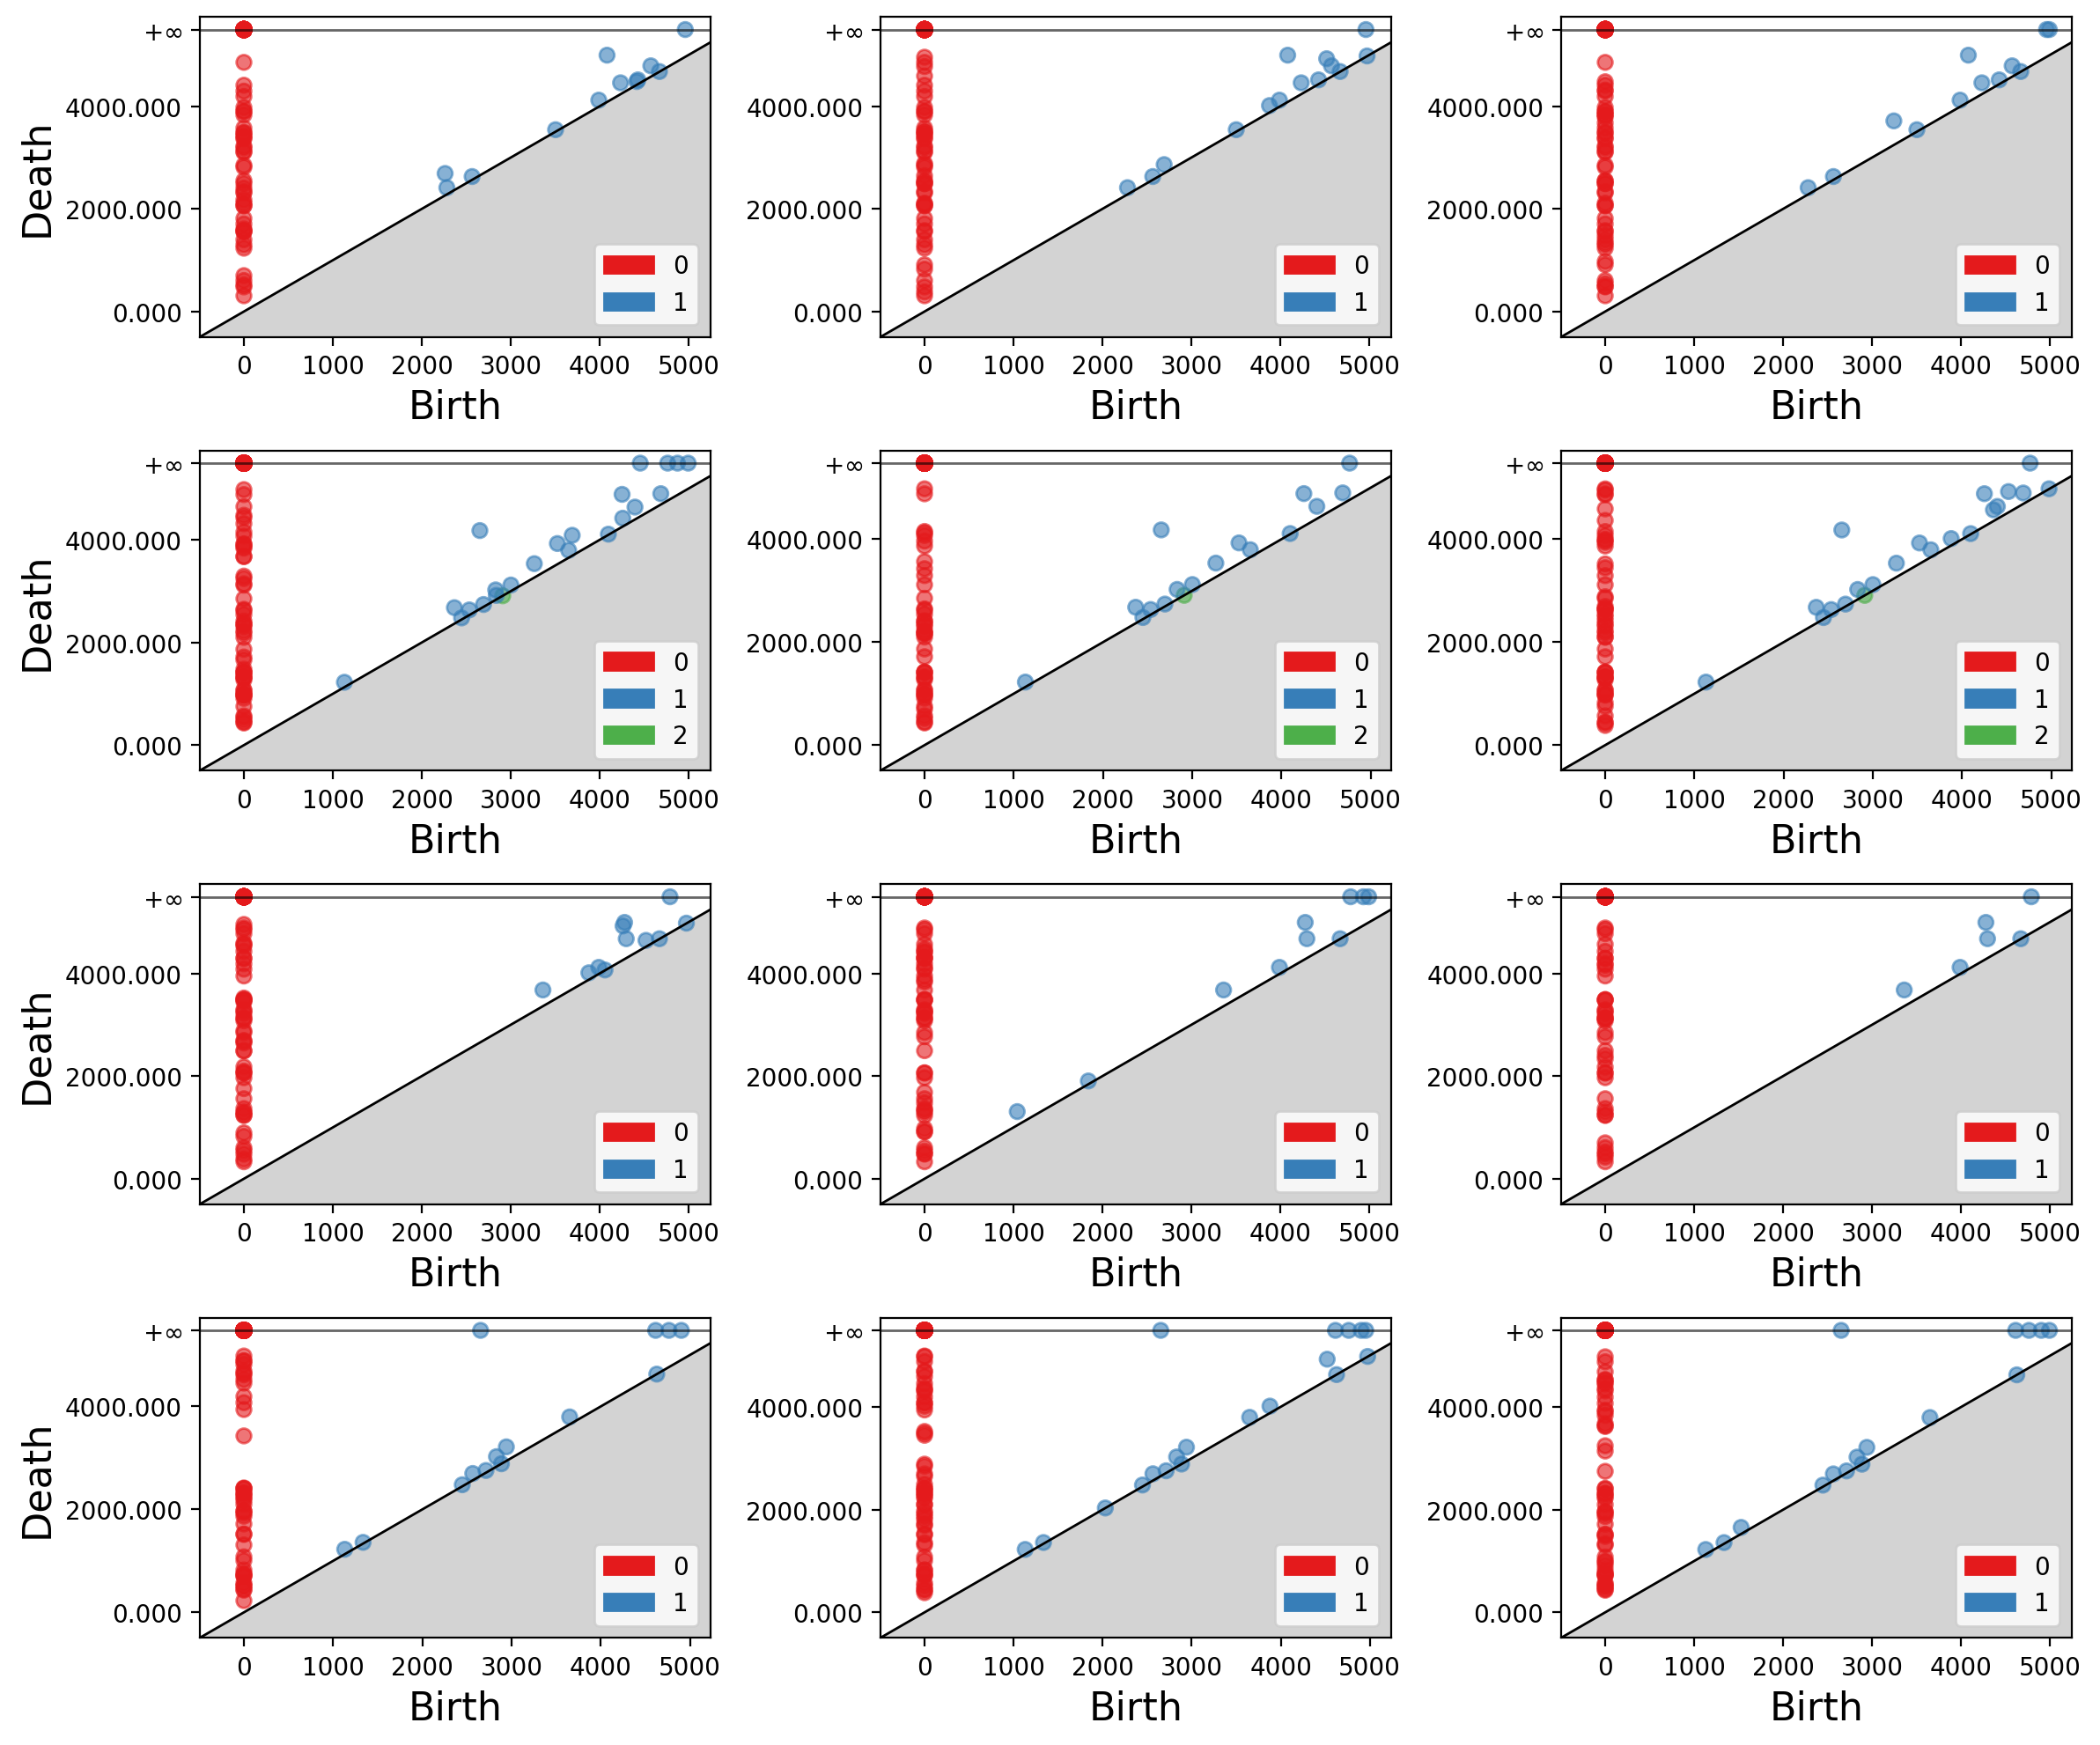

In [15]:
fig, ax = plt.subplots(4,3, figsize = (12, 10))
for ii, d in enumerate(diag[::9]):

    if (ii%12 == 0) and (ii != 0):
        fig, ax = plt.subplots(4,3, figsize = (12, 10))
        gudhi.plot_persistence_diagram(d, axes = ax[ii%4, ii%3])
        ax[ii%4, ii%3].set_title("")

        if ((ii%3 == 1) or (ii%3 == 2)):
            ax[ii%4, ii%3].set_ylabel("")
        plt.tight_layout()

    else:
        gudhi.plot_persistence_diagram(d, axes = ax[ii%4, ii%3])
        ax[ii%4, ii%3].set_title("")
        if ((ii%3 == 1) or (ii%3 == 2)):
            ax[ii%4, ii%3].set_ylabel("")
        plt.tight_layout()
    


In [16]:
# xt = np.array([(birth, death) for (dim, (birth, death)) in diag[0]])[:,0]
# yt = np.array([(birth, death) for (dim, (birth, death)) in diag[0]])[:,1]

# X = np.vstack([xt, yt]).reshape(len(xt),2)


# xt = np.array([(birth, death) for (dim, (birth, death)) in diag[1]])[:,0]
# yt = np.array([(birth, death) for (dim, (birth, death)) in diag[1]])[:,1]

# Y = np.vstack([xt, yt]).reshape(len(xt),2)


In [17]:
# wasserstein_distance(X, Y)

In [18]:
len(diag)

216

# Extract the birth and death of the PD

In [19]:
Y = []
for d in diag:
    xt = np.array([(birth, death) for (dim, (birth, death)) in d])
    # -- convert the inf to 6000 (upper limit)
    xt[~np.isfinite(xt)] = 6000
    # yt = np.array([(birth, death) for (dim, (birth, death)) in d])[:,1]
    # yt[~np.isfinite(yt)] = 20000
    Y.append(xt)

In [20]:
len(Y)

216

In [21]:
Y[3][:3]

array([[3415.05917558, 3429.82384882],
       [4973.96366961, 6000.        ],
       [4962.64310974, 6000.        ]])

In [22]:
diag[3][:3]

[(2, (3415.0591755794176, 3429.8238488203115)),
 (1, (4973.963669614009, inf)),
 (1, (4962.643109738856, inf))]

In [23]:
wasserstein_distance(Y[0], Y[3])

35260.71987287224

In [24]:
# import scipy.stats as stats

# Calculate the wasserstein distance

In [25]:
distance = np.zeros((len(Y), len(Y)))
distance_sc = np.zeros((len(Y), len(Y)))

for jj in range(len(Y)):
    for kk in range(len(Y)):
        distance[jj][kk] = wasserstein_distance(Y[jj], Y[kk])
        # distance_sc[jj][kk] = stats.wasserstein_distance(Y[jj], Y[kk])

In [26]:
with open('distance_wd.pkl', 'wb') as file:
    pickle.dump(distance, file)


In [27]:
distance.shape

(216, 216)

In [28]:
# normalize the wasserstein distance between 0 and 1
distance_norm = (distance- distance.min()) / (distance.max() - distance.min() )

# Histogram the normalize wasserstein distance

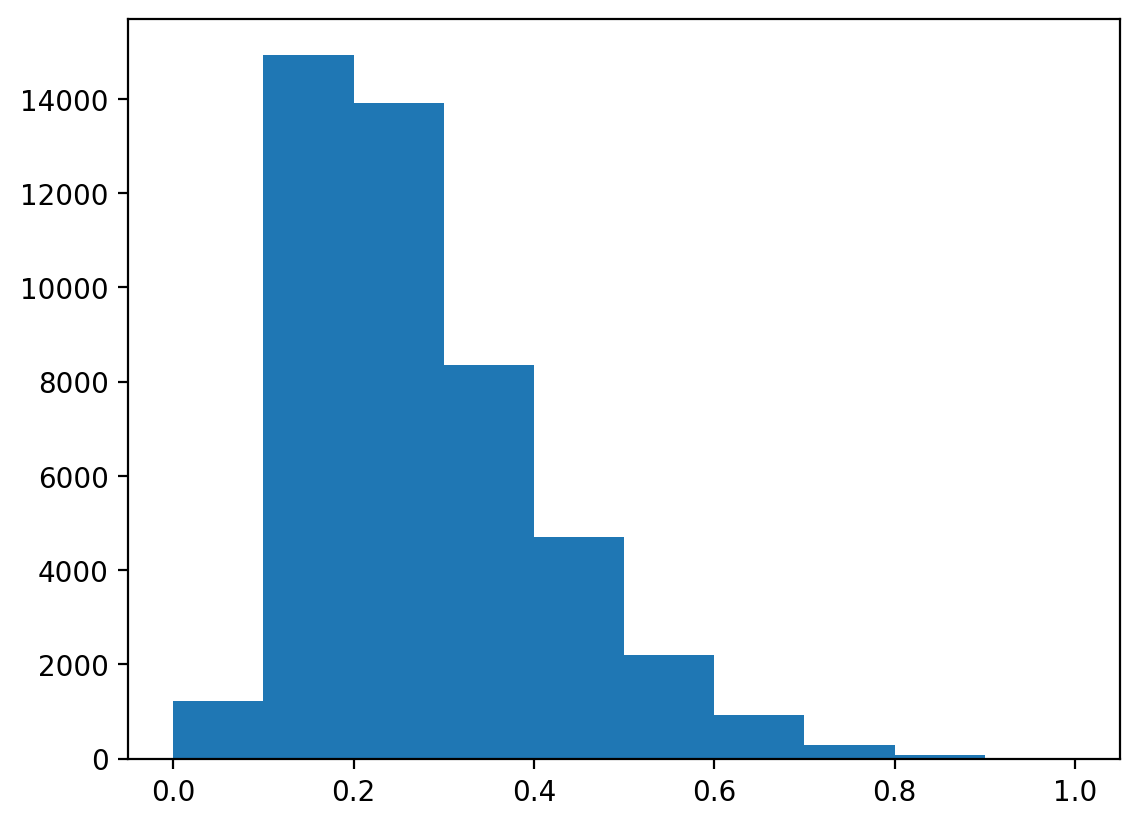

In [29]:
plt.hist(distance_norm.flatten());

In [30]:
np.percentile(distance_norm, 99)

0.683411418332616

In [31]:
distance_norm[3,64]

0.6901009887880168

In [32]:
indexes_hwd = np.argwhere(distance_norm > np.percentile(distance_norm, 99))

In [33]:
indexes_hwd[:3]

array([[  3,  64],
       [  3, 136],
       [  6,  75]])

# Plot some PD where the wasserstein distance > 99% of the rest of the distances

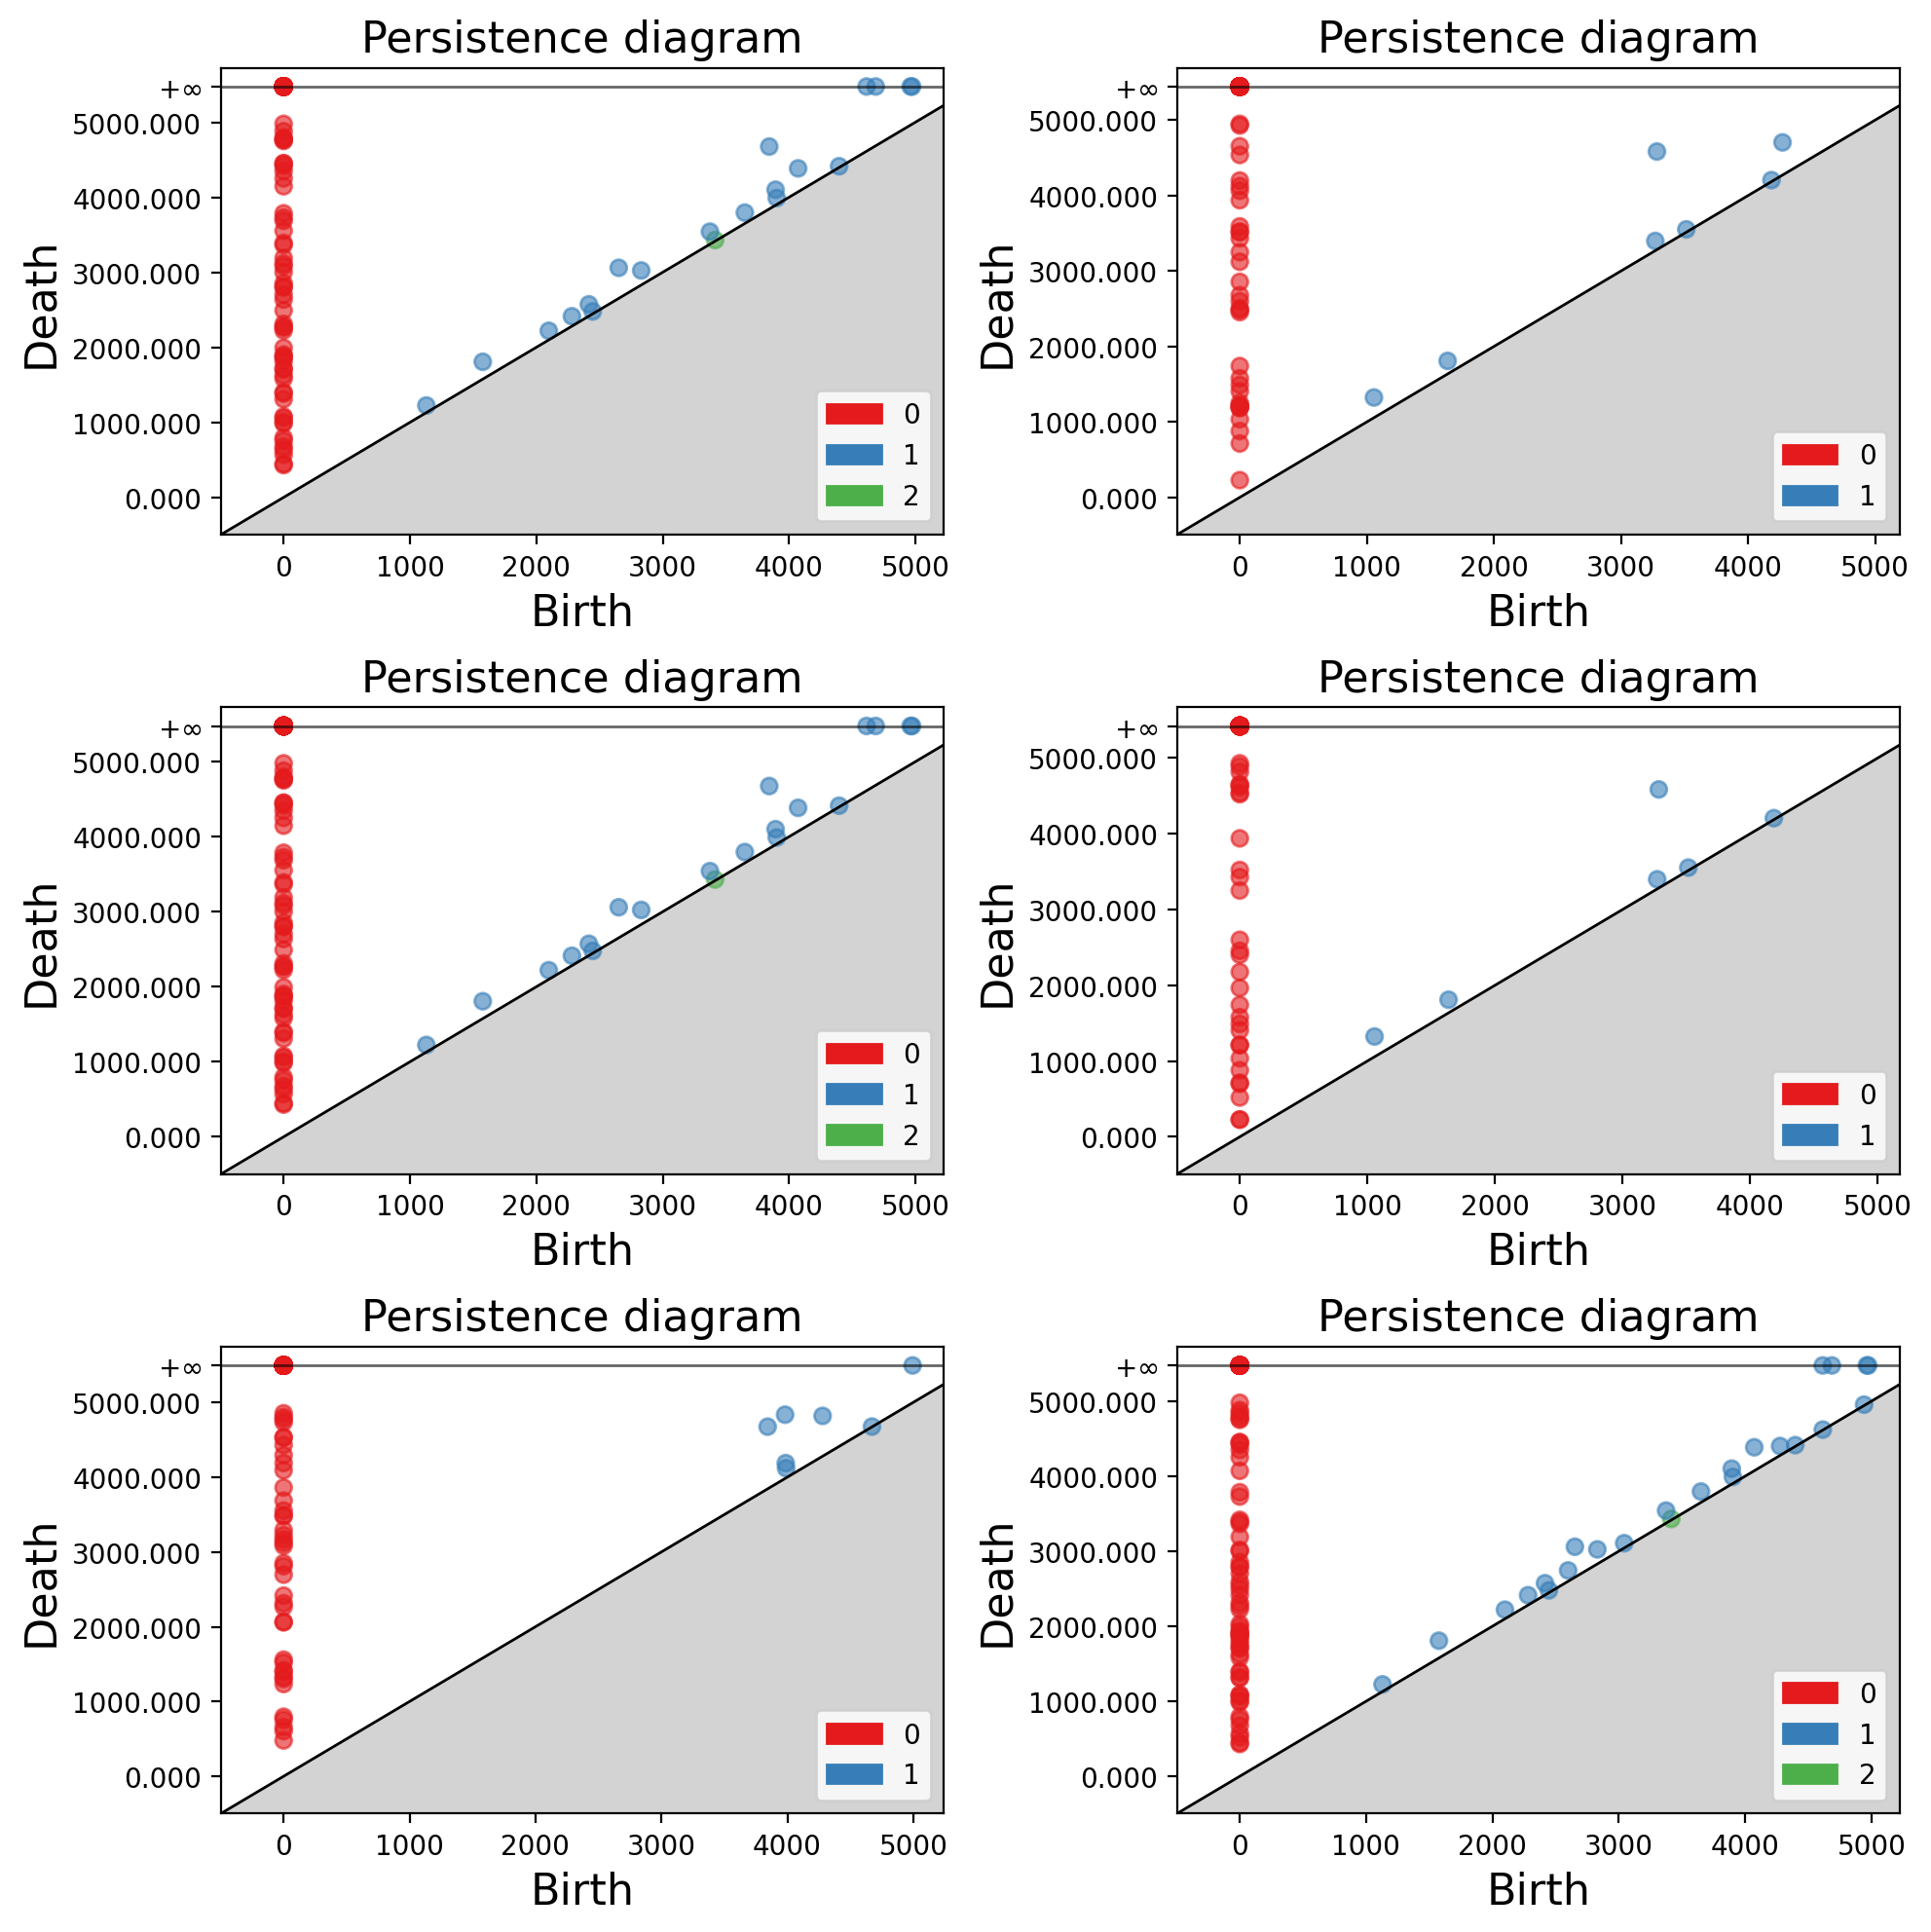

In [34]:
fig, ax = plt.subplots(3,2, figsize = (10,10))
gudhi.plot_persistence_diagram(diag[3], axes = ax[0,0])
gudhi.plot_persistence_diagram(diag[64], axes = ax[0,1])

gudhi.plot_persistence_diagram(diag[3], axes = ax[1,0])
gudhi.plot_persistence_diagram(diag[136], axes = ax[1,1])

gudhi.plot_persistence_diagram(diag[6], axes = ax[2,0])
gudhi.plot_persistence_diagram(diag[75], axes = ax[2,1])

plt.tight_layout()


In [35]:
indexes_lwd = np.argwhere(distance_norm < np.percentile(distance_norm, 1))
indexes_lwd[:3]

array([[ 0,  0],
       [ 0, 36],
       [ 1,  1]])

# Plot some PD where the wasserstein distance <> 1% of the rest of the distances

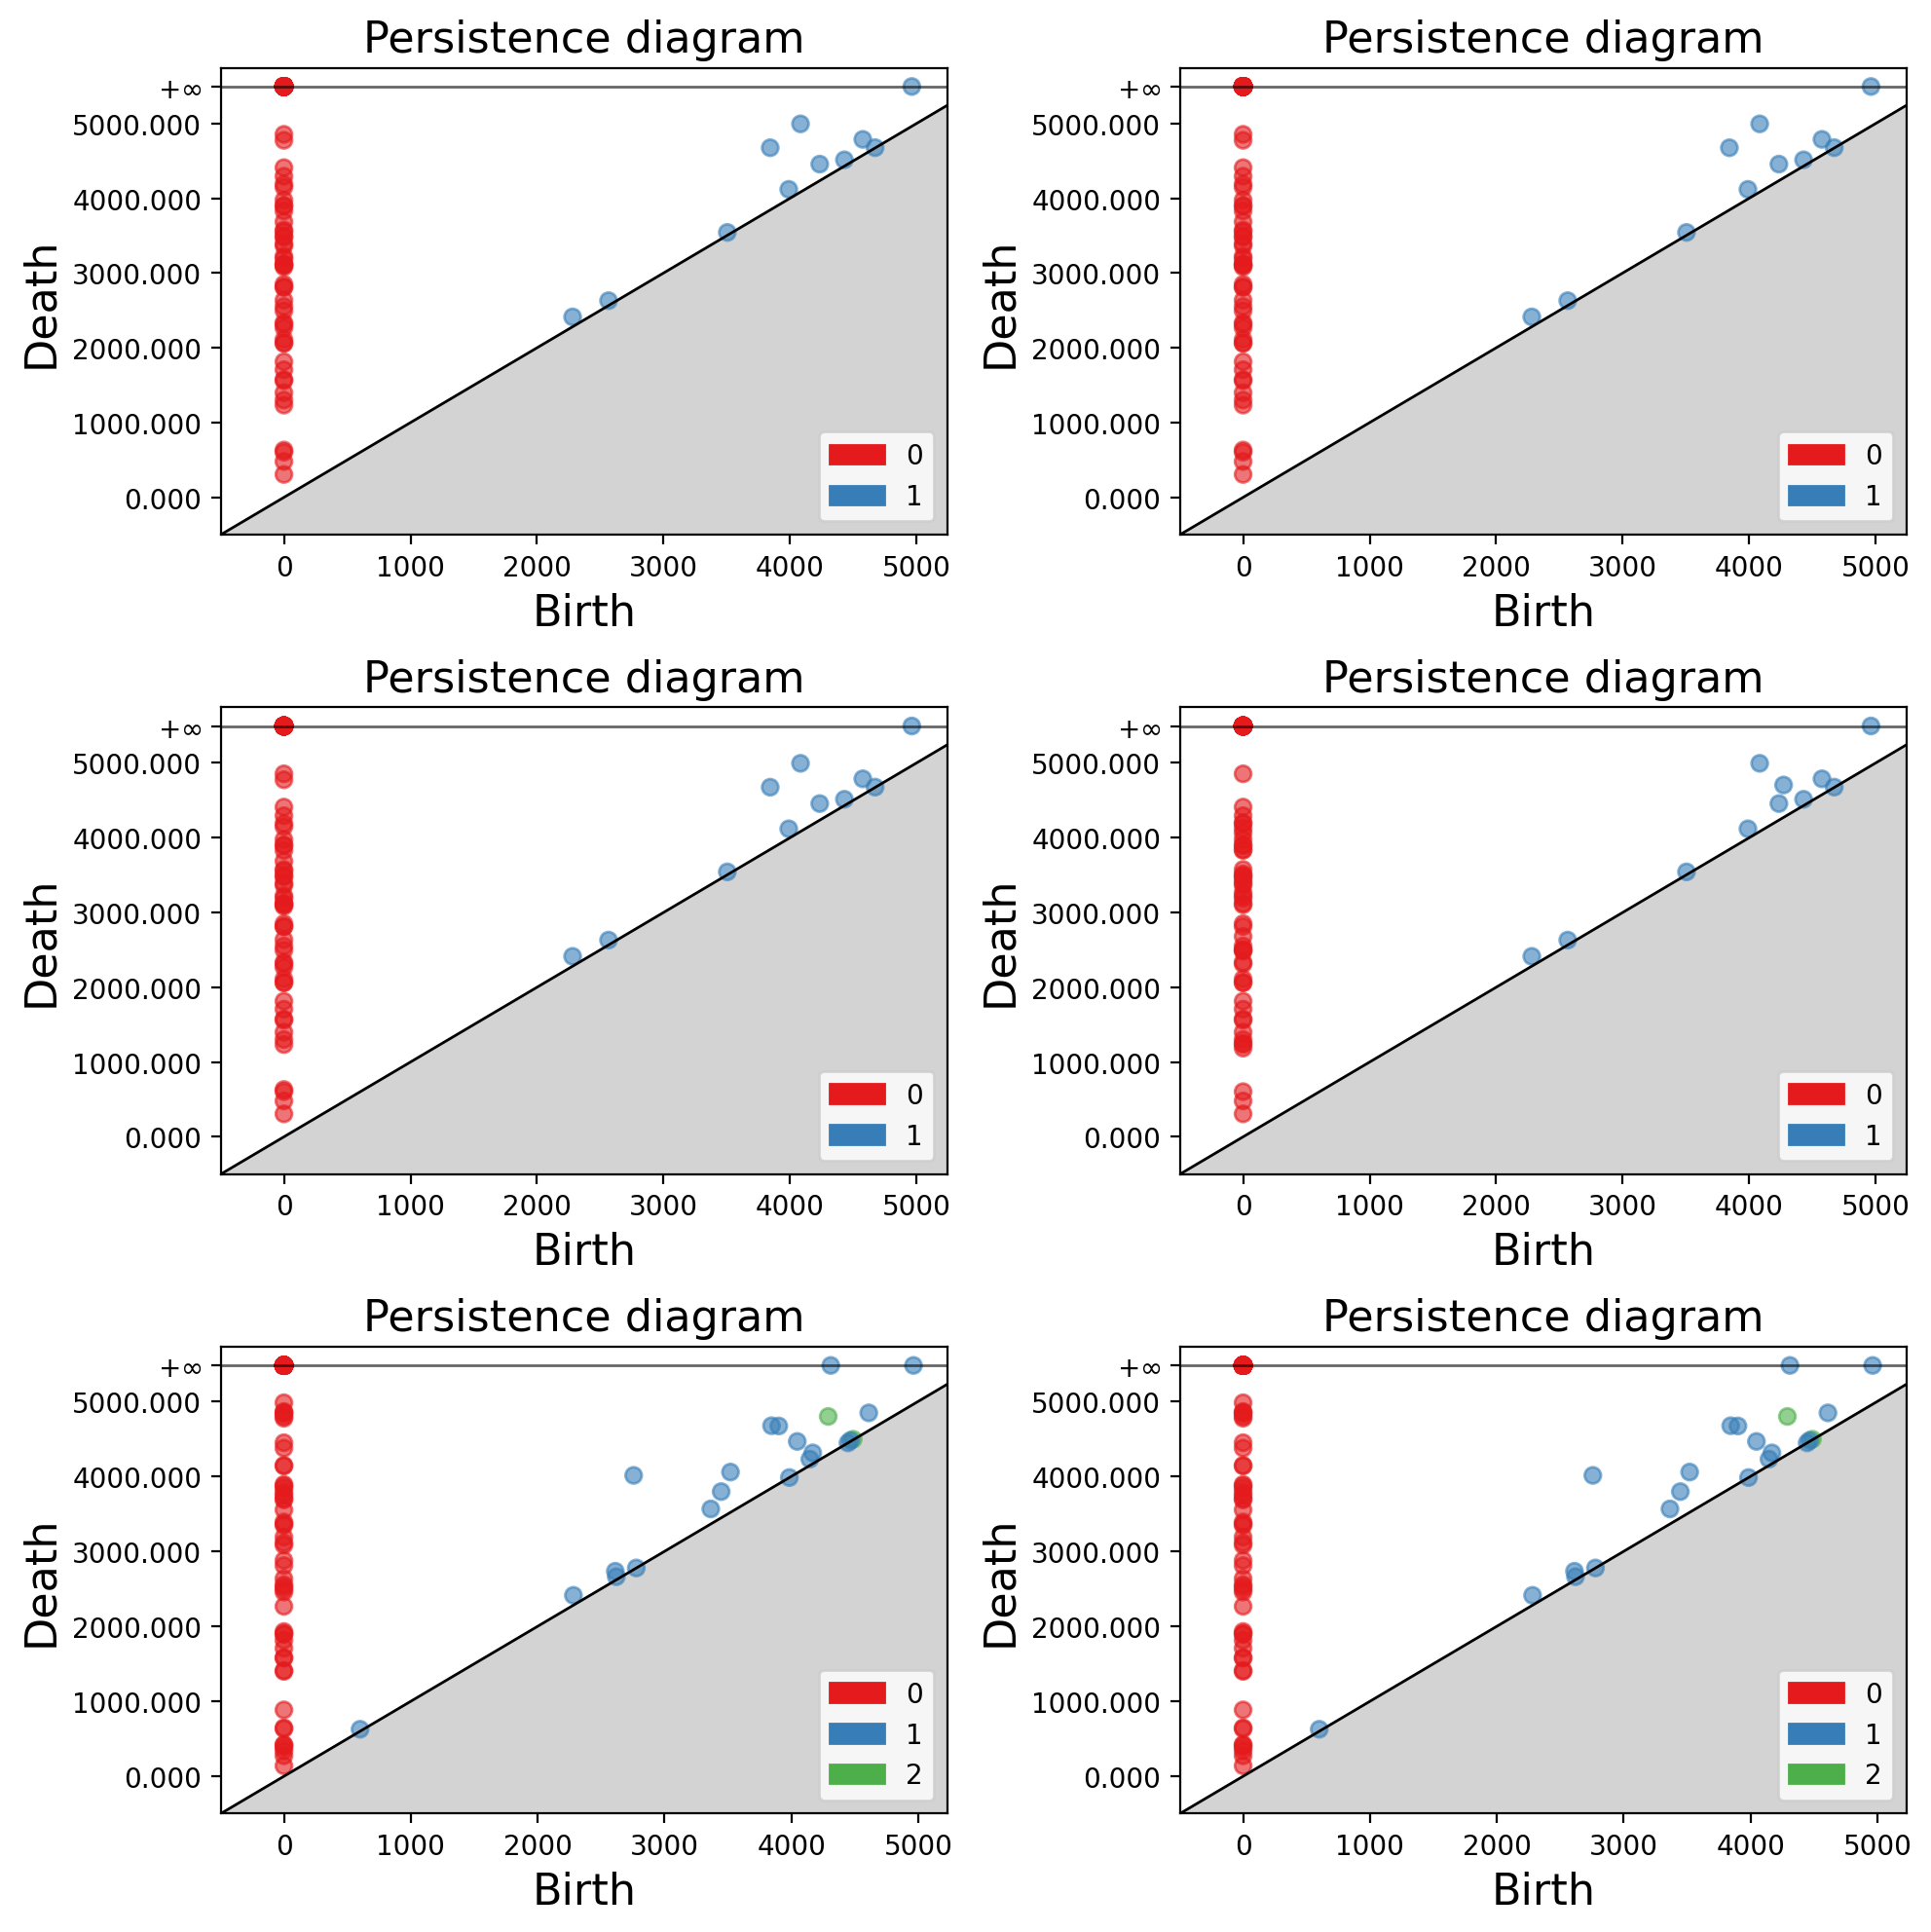

In [36]:
fig, ax = plt.subplots(3,2, figsize = (10,10))
gudhi.plot_persistence_diagram(diag[0], axes = ax[0,0])
gudhi.plot_persistence_diagram(diag[0], axes = ax[0,1])

gudhi.plot_persistence_diagram(diag[0], axes = ax[1,0])
gudhi.plot_persistence_diagram(diag[36], axes = ax[1,1])

gudhi.plot_persistence_diagram(diag[1], axes = ax[2,0])
gudhi.plot_persistence_diagram(diag[1], axes = ax[2,1])

plt.tight_layout()

# T-SNE & Kmeans

/home/taceroc/.local/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


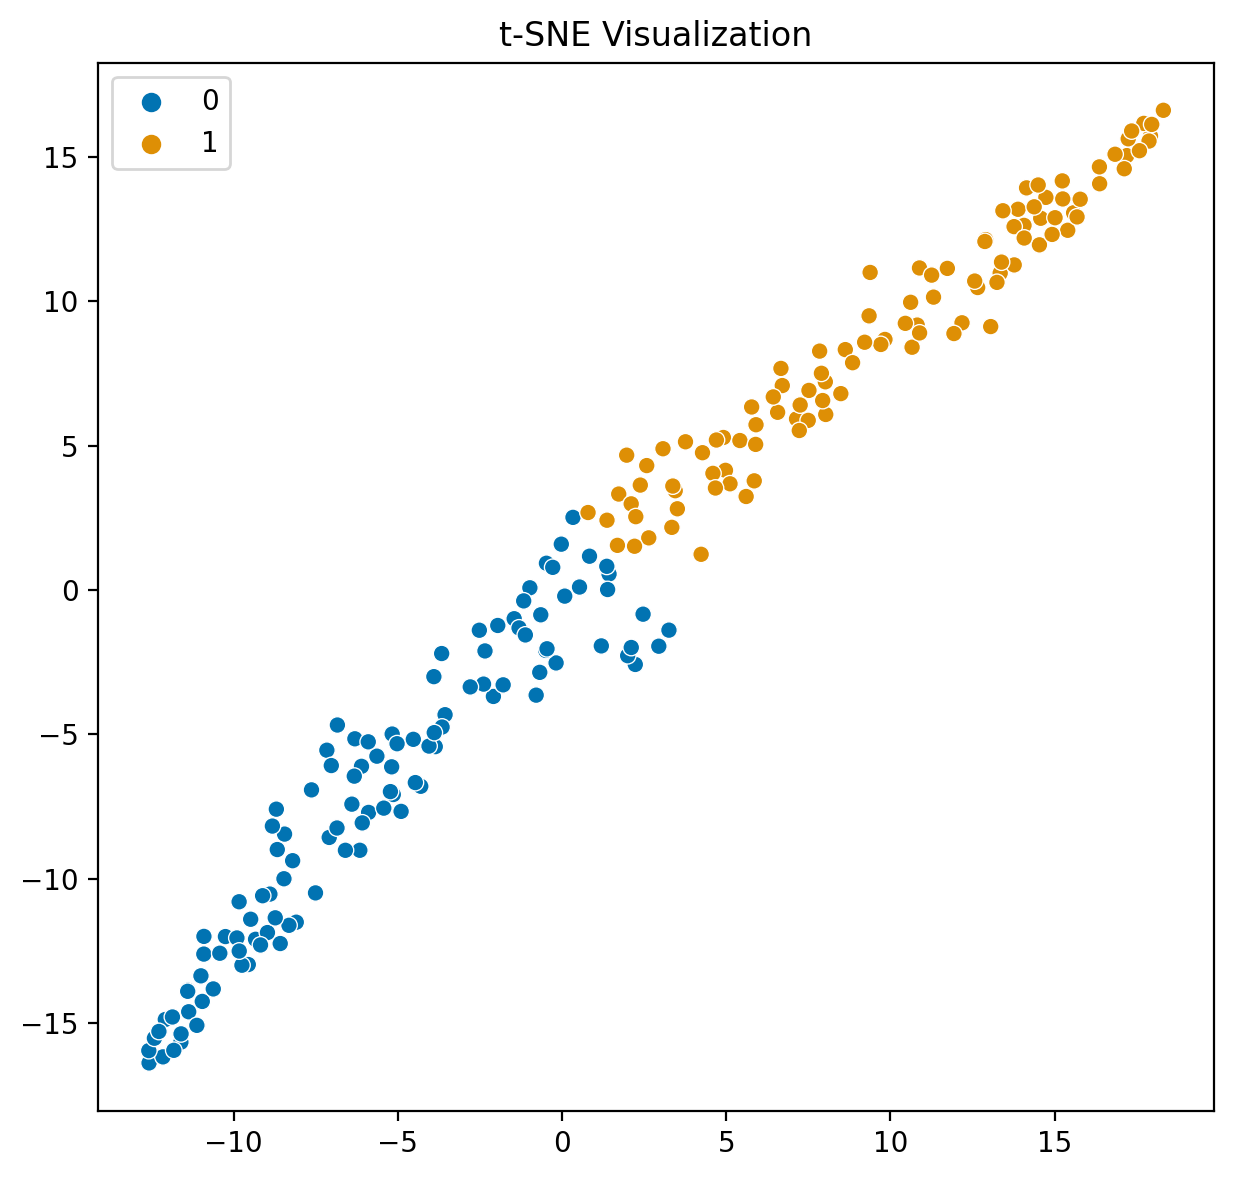

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


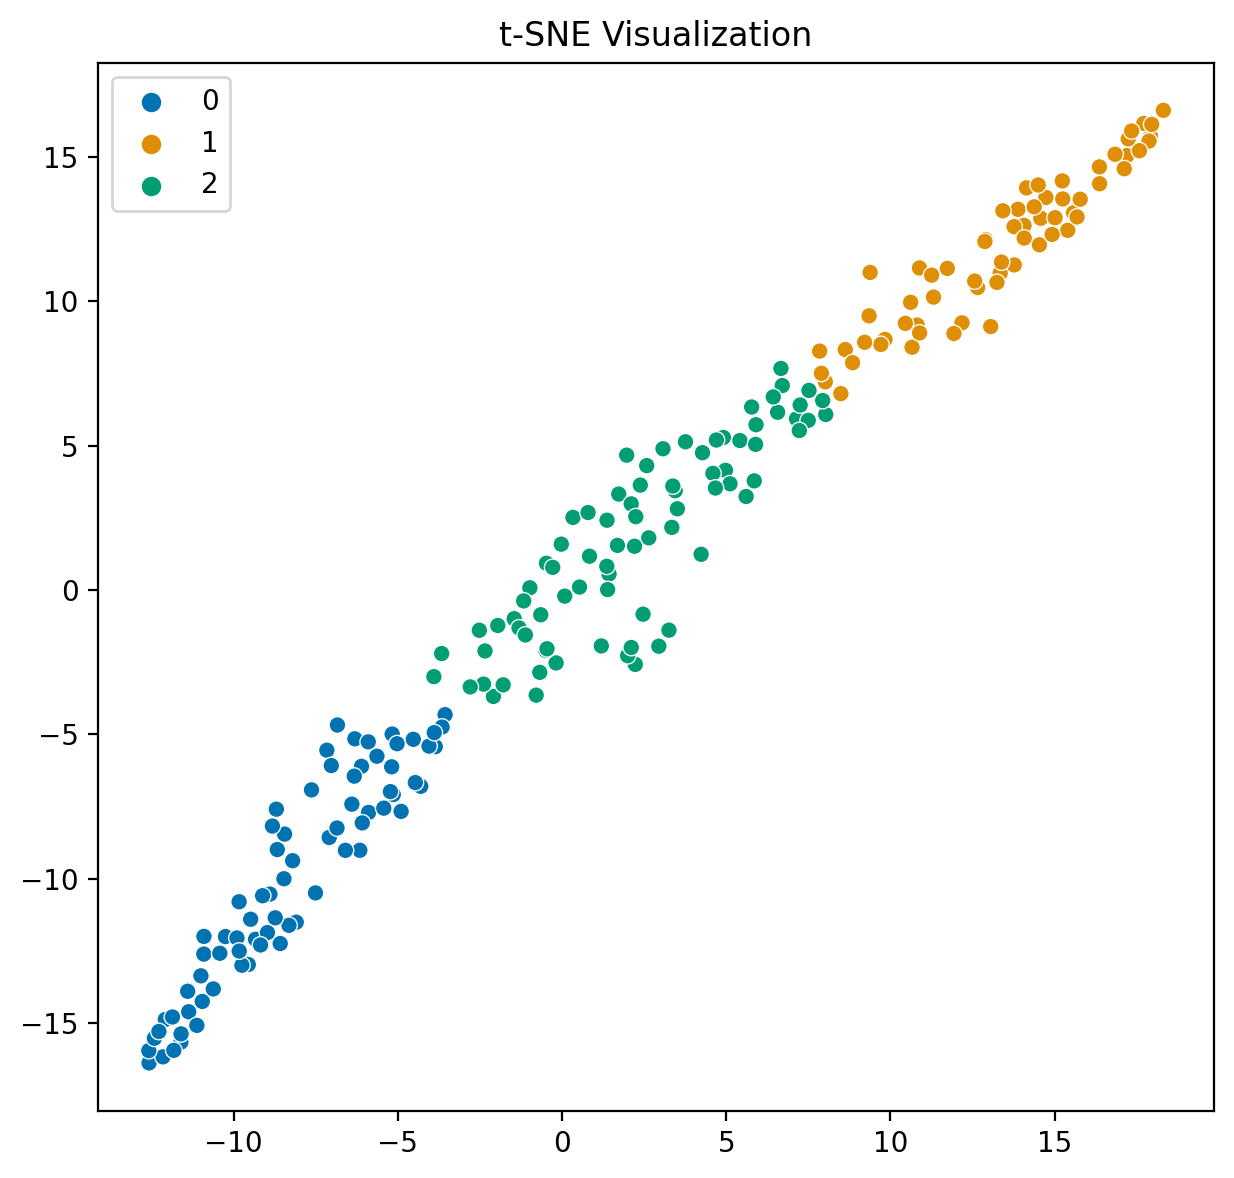

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


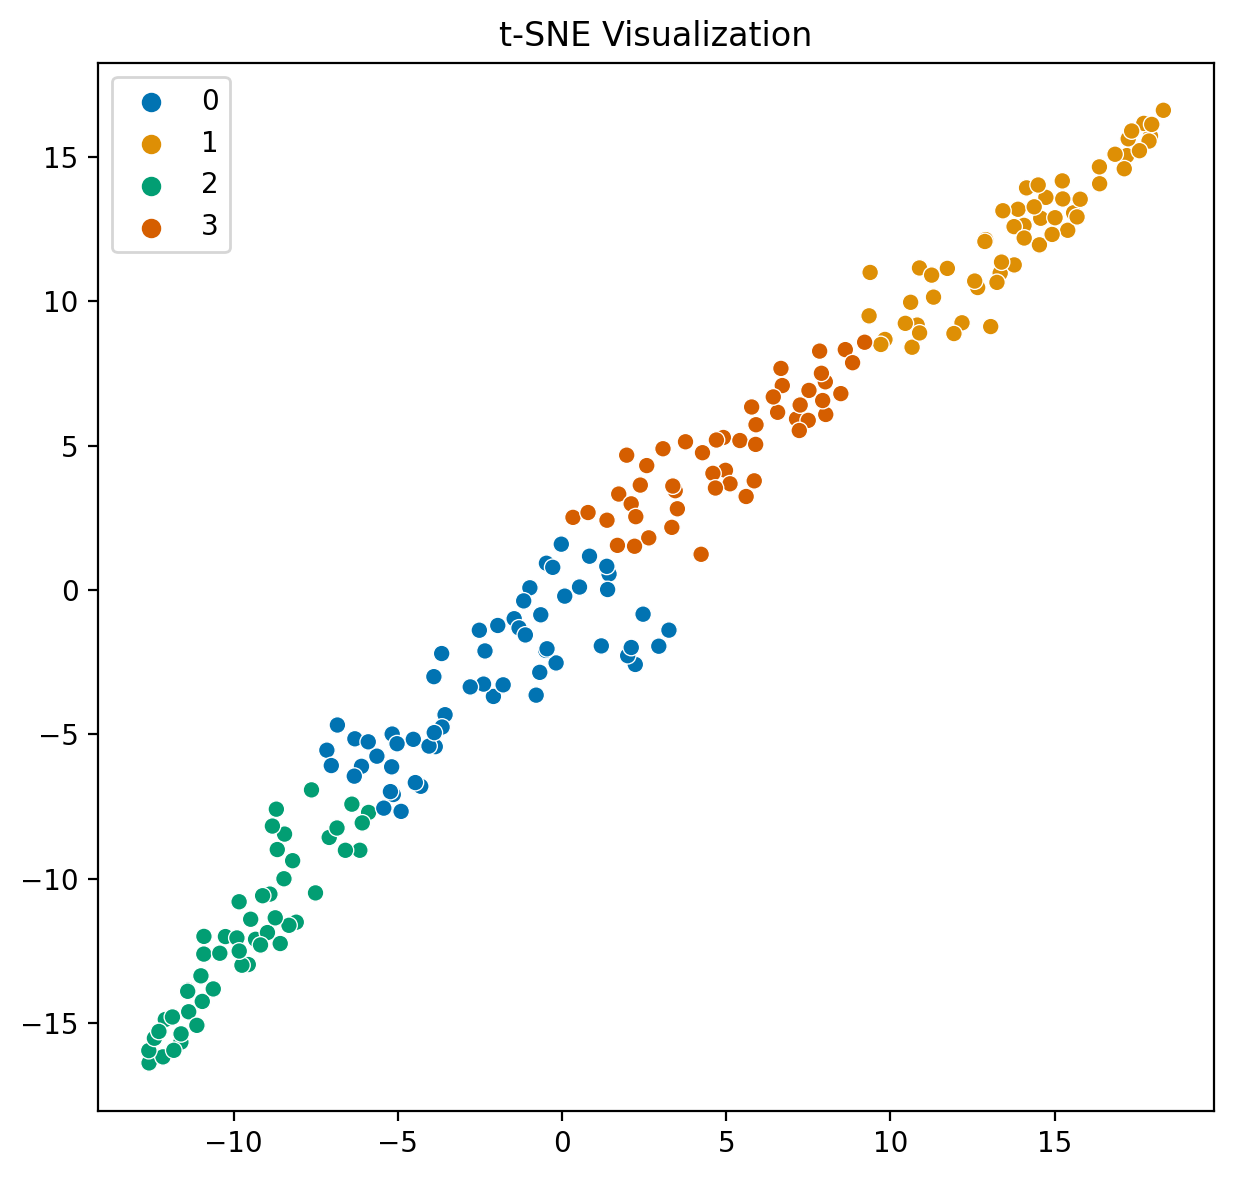

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


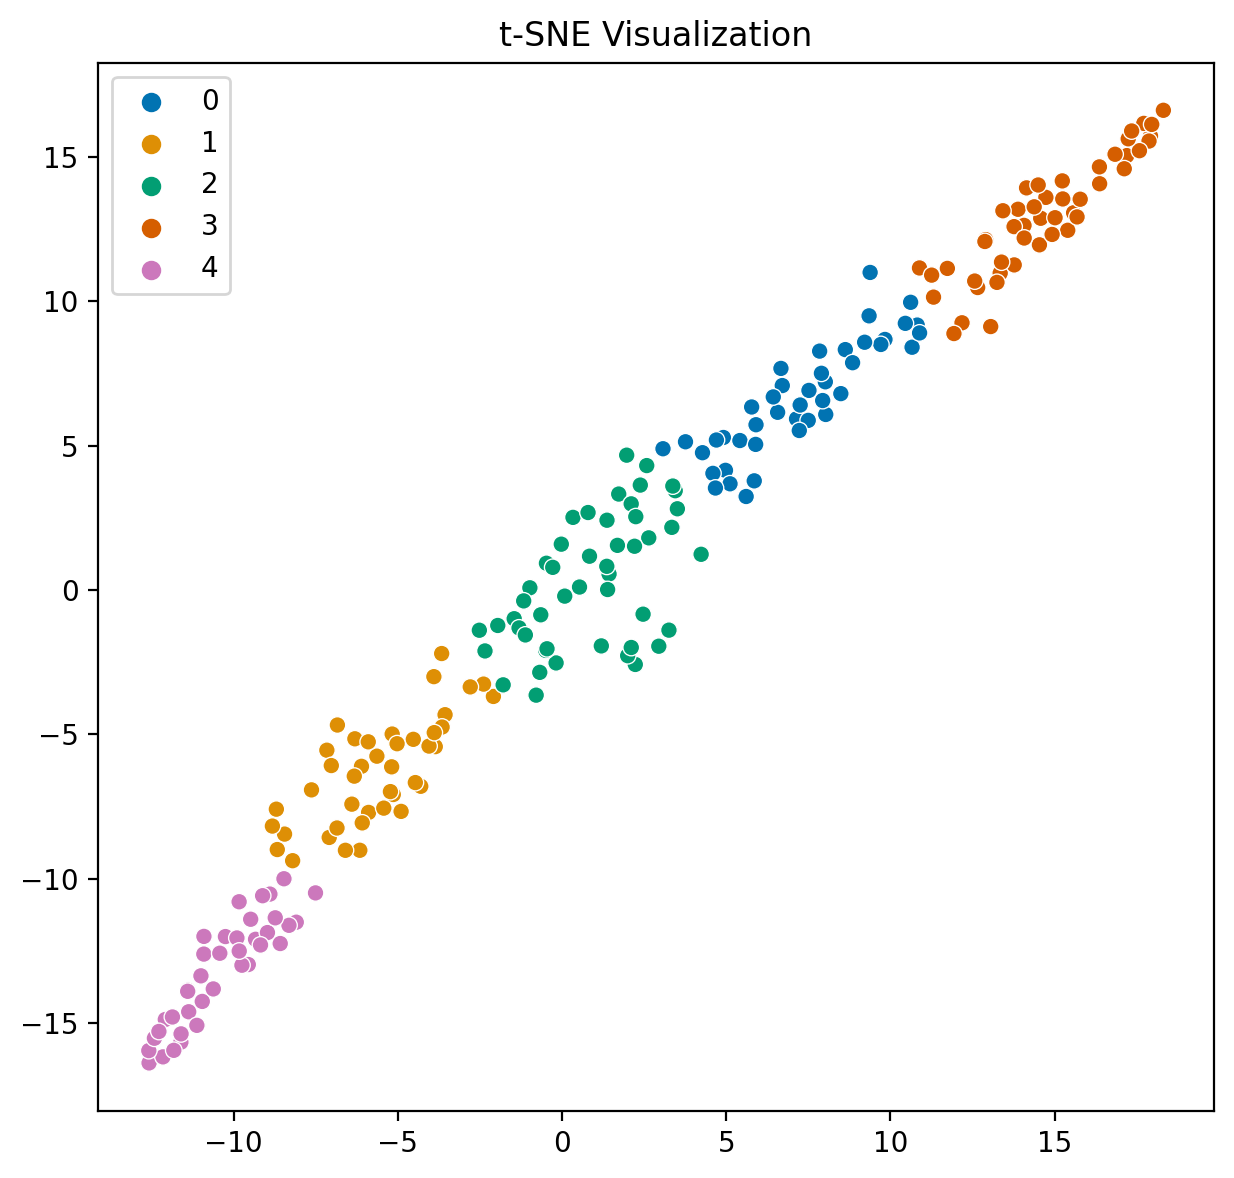

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


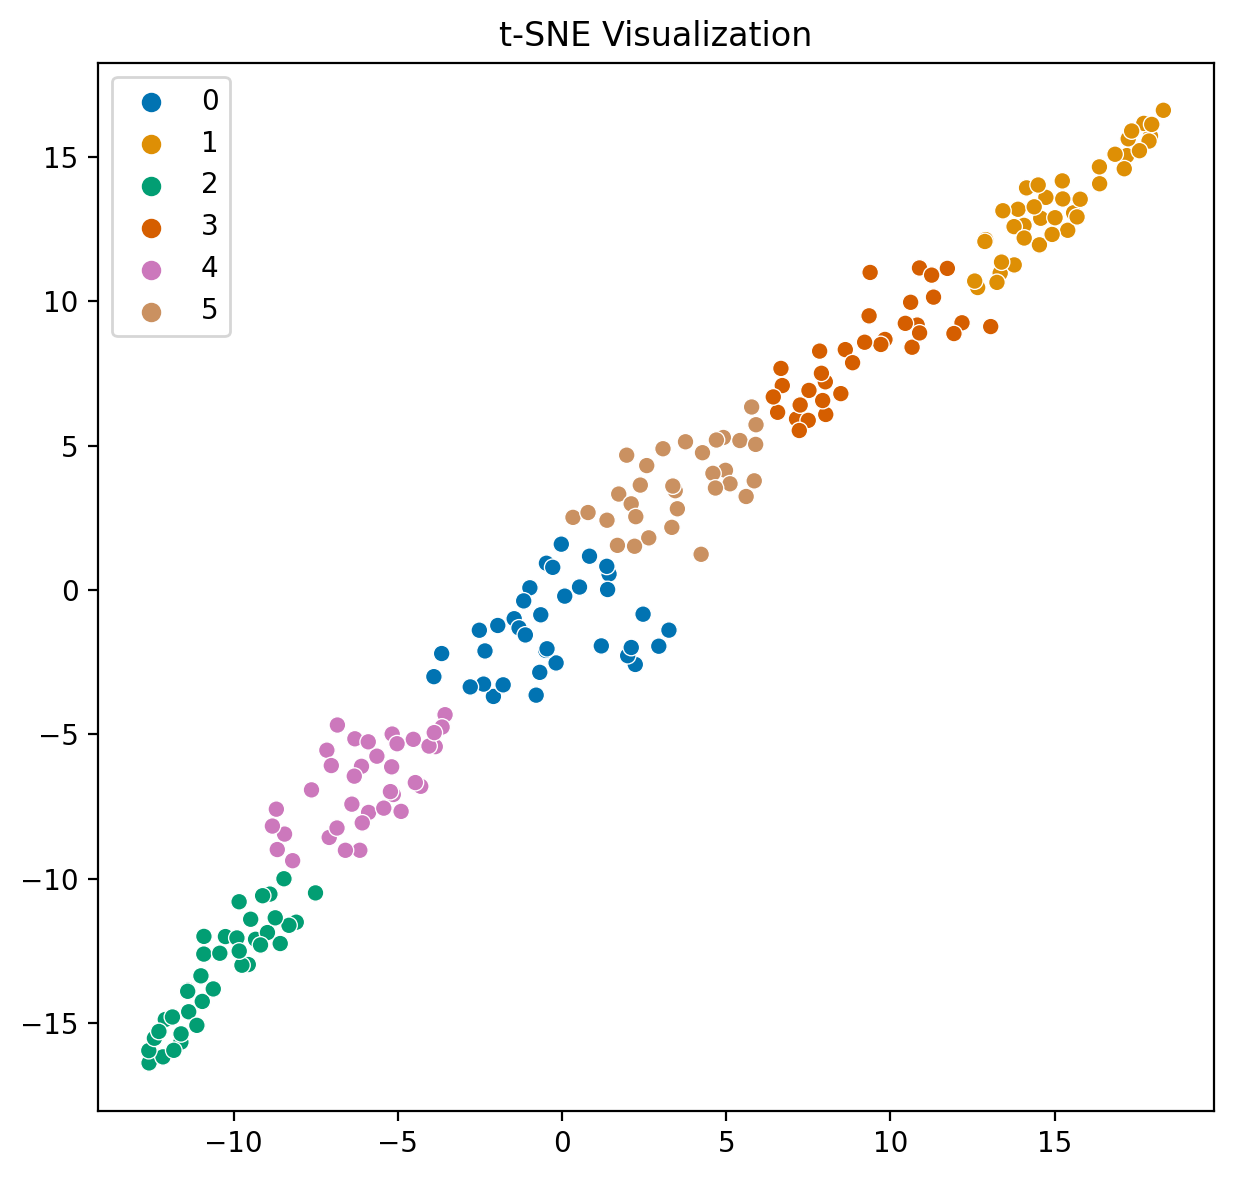

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


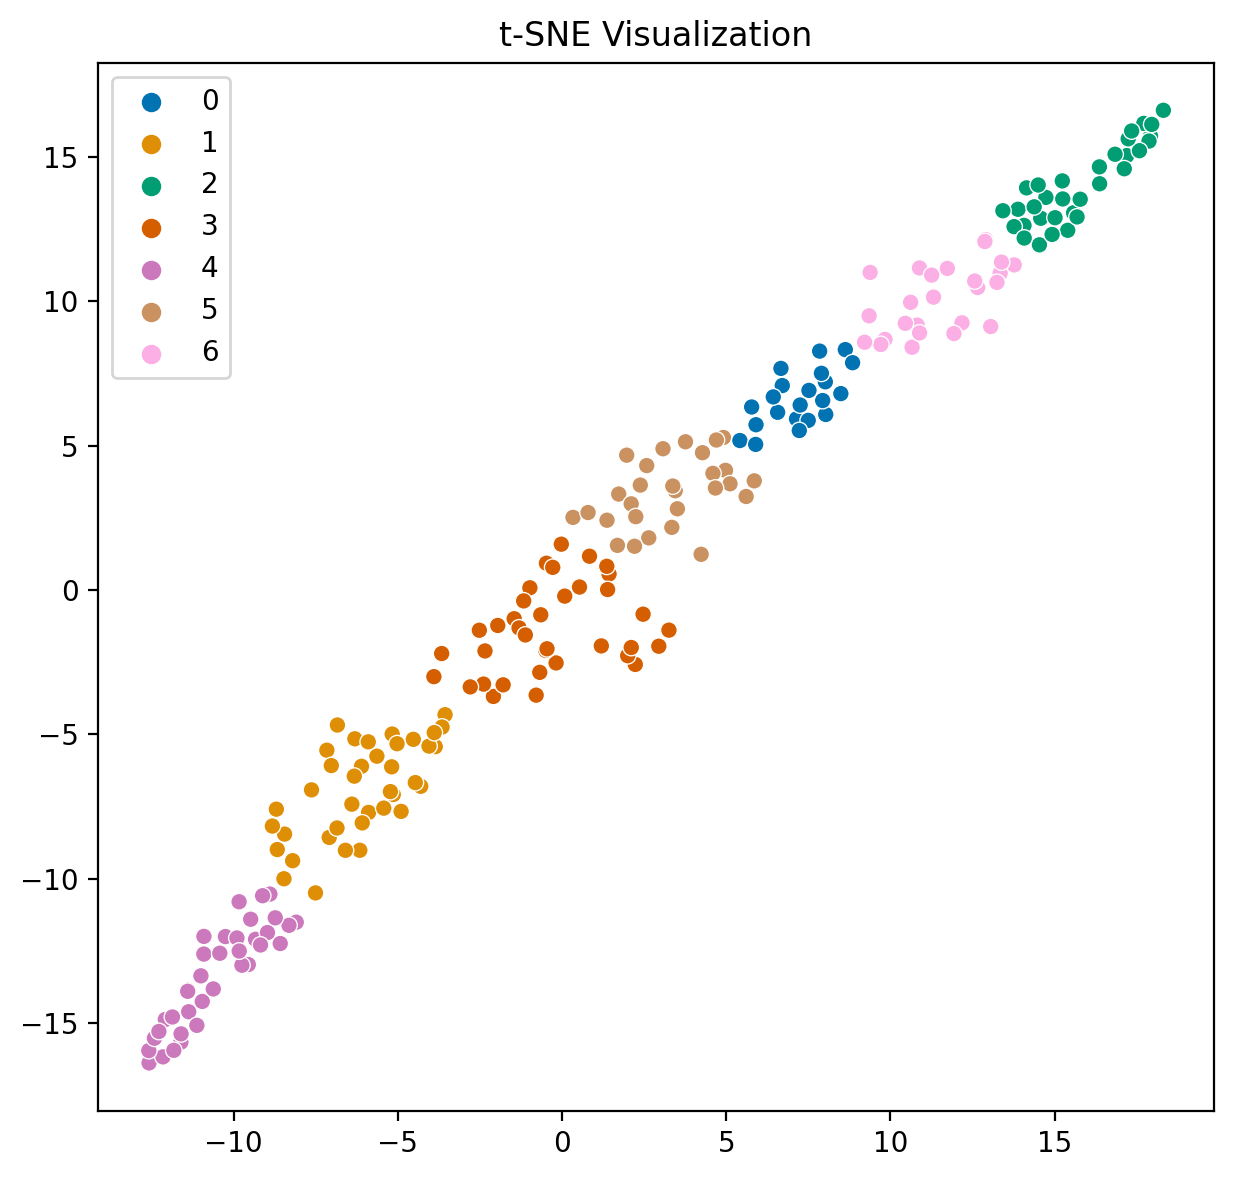

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


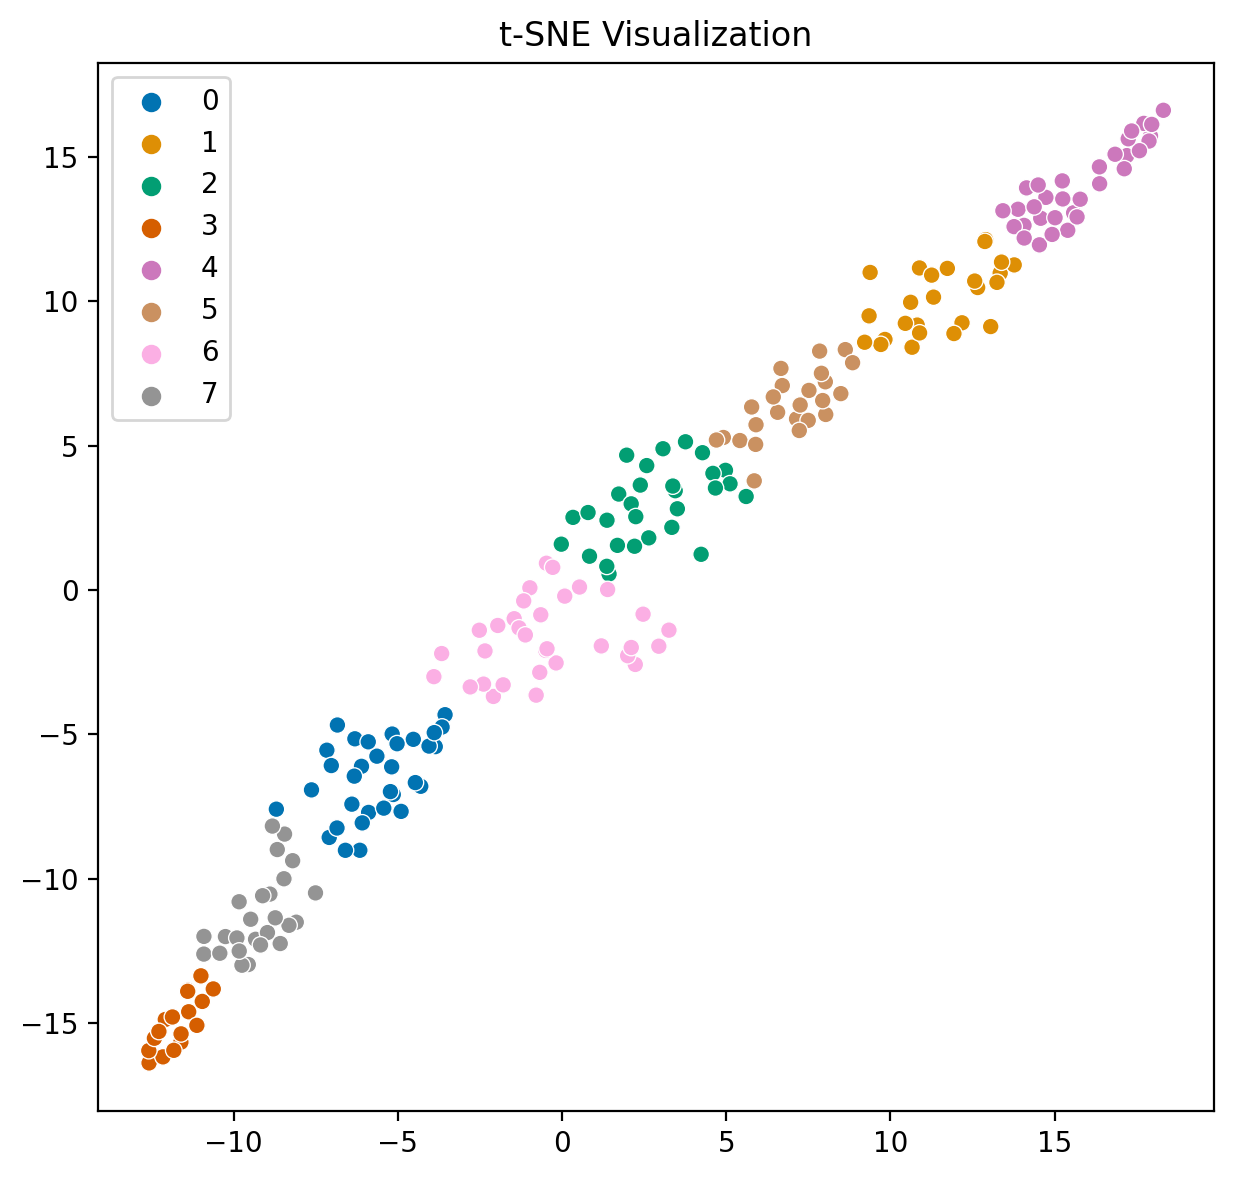

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


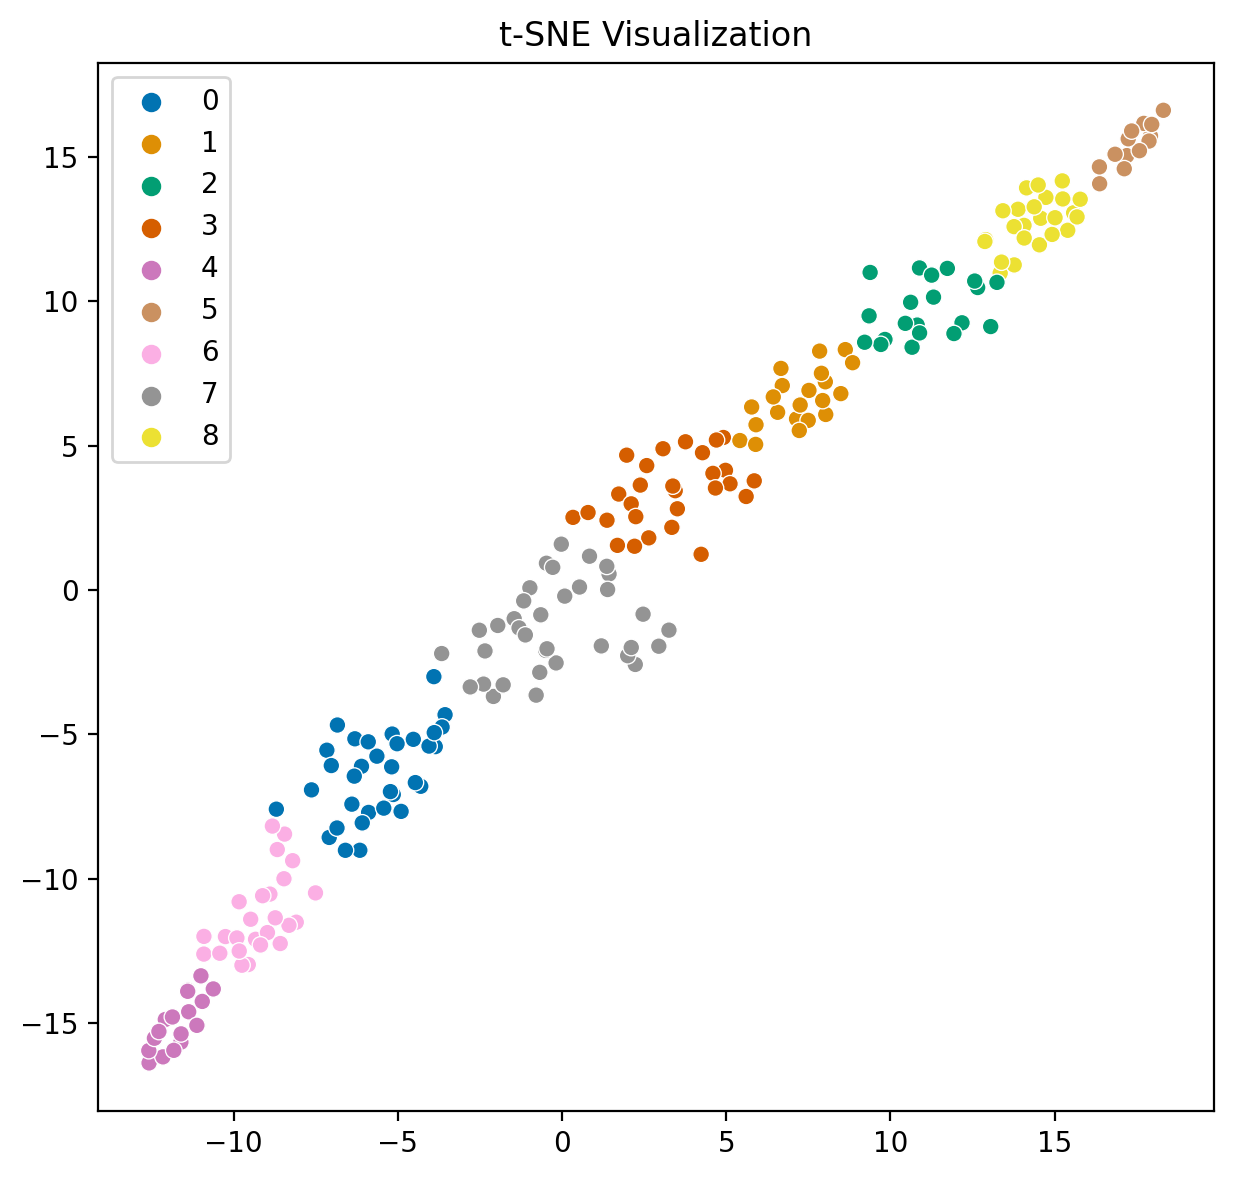

/home/taceroc/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


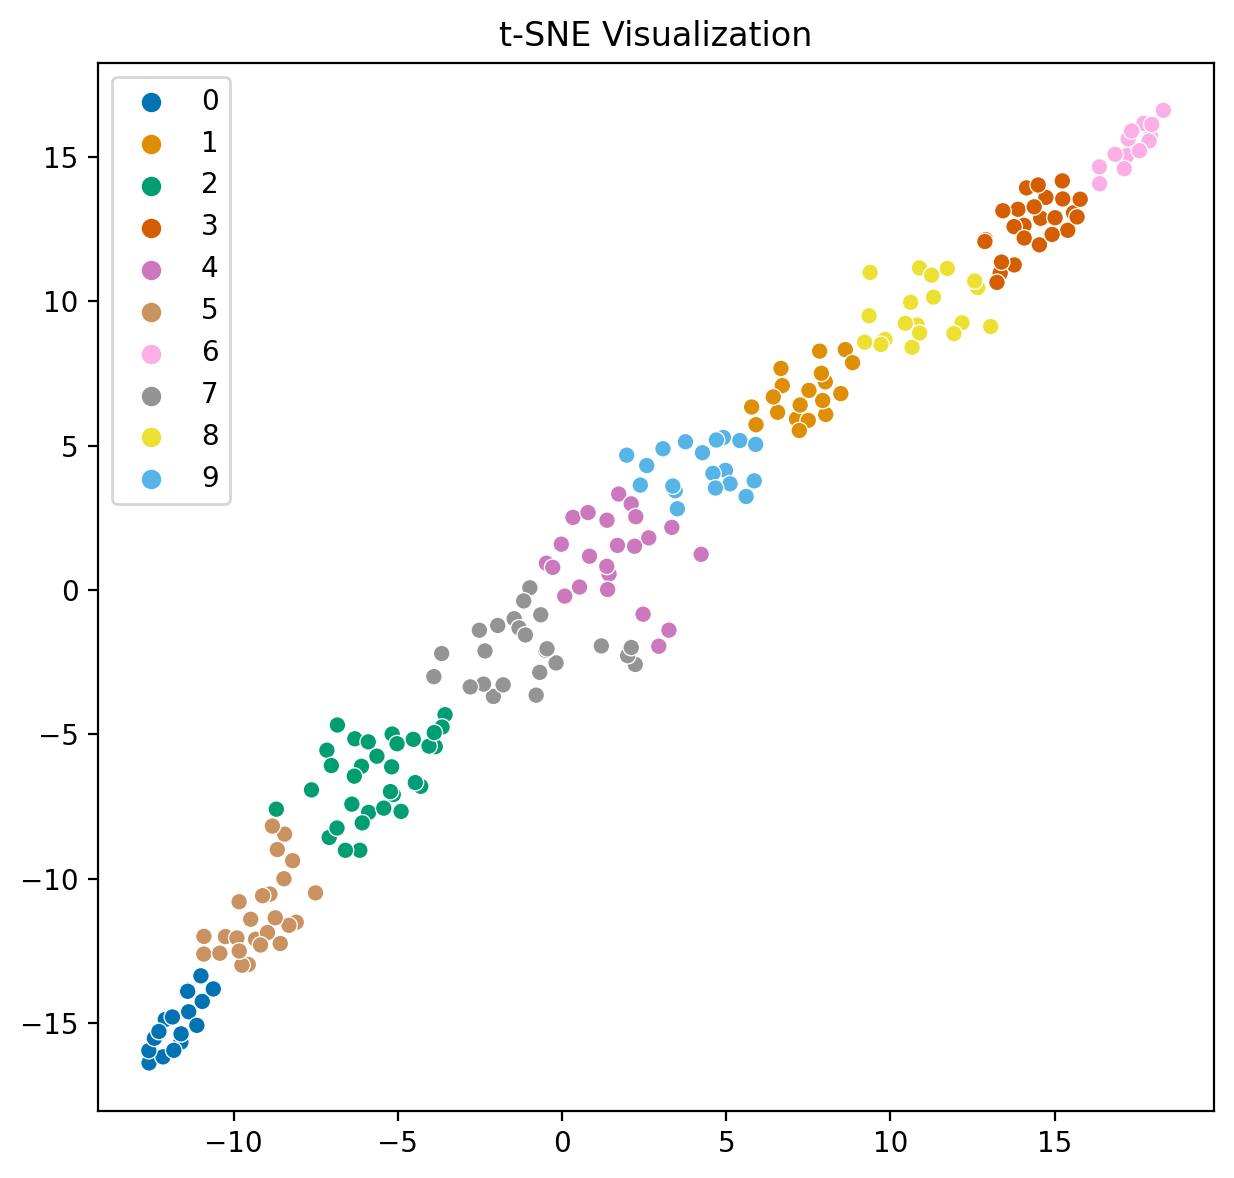

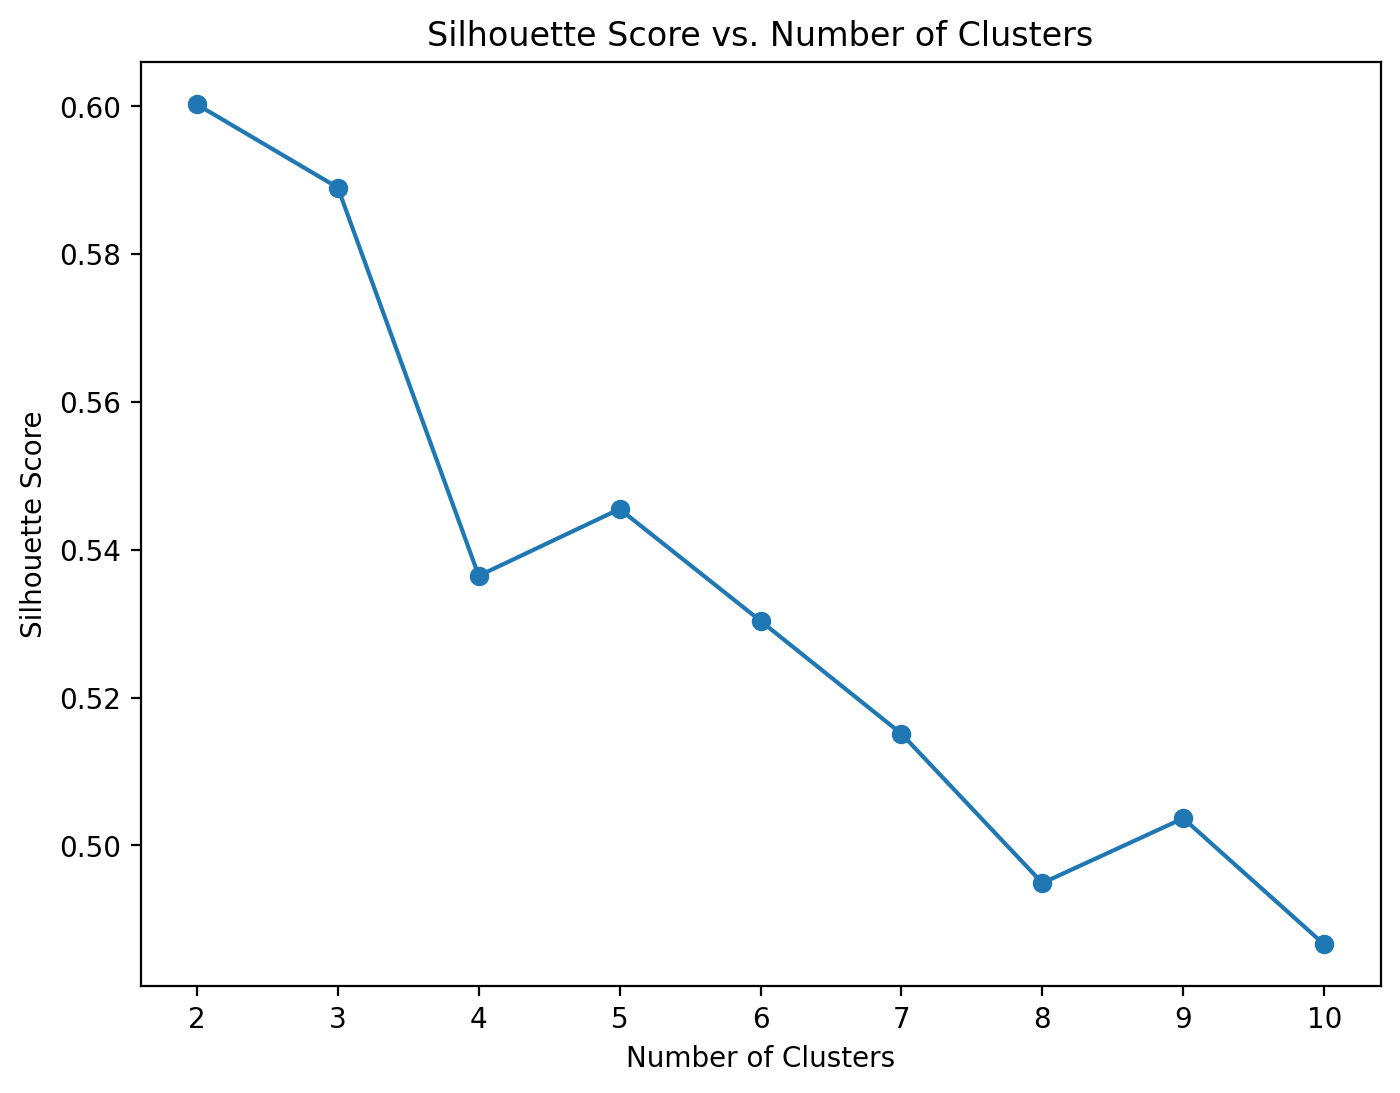

In [37]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

def perform_tsne(data, n_components=2, perplexity=30, learning_rate=200):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

def perform_kmeans(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data)
    labels = kmeans.labels_
    return labels, kmeans.cluster_centers_

def perform_isolation_forest(data):
    iso_forest = IsolationForest(contamination='auto')
    iso_forest.fit(data)
    anomalies = iso_forest.predict(data)
    return anomalies

def visualize_results(tsne_result, labels, anomalies):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette='colorblind', legend='full')
    plt.title('t-SNE Visualization')
   
    # plt.subplot(1, 2, 2)
    # sns.countplot(anomalies)
    # plt.title('Anomaly Distribution')

    plt.tight_layout()
    plt.show()

def main():
    # Load your data into 'data_matrix'
    data_matrix = distance.copy()
   
    tsne_result = perform_tsne(data_matrix)

    # Range of cluster numbers to try
    cluster_range = range(2, 11)

    silhouette_scores = []

    for num_clusters in cluster_range:
        labels, cluster_centers = perform_kmeans(tsne_result, num_clusters)
        anomalies = perform_isolation_forest(tsne_result)
        silhouette_scores.append(silhouette_score(tsne_result, labels))

        visualize_results(tsne_result, labels, anomalies)

    # Plot silhouette scores for different cluster numbers
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.show()

if __name__ == "__main__":
    main()